# ROC on openpifpaf

In [1]:
from mlworkflow import PickledDataset, TransformedDataset
from dataset_utilities.ds.instants_dataset import ExtractViewData, ViewCropperTransform

from openpifpaf.datasets.deepsport import AddBallSegmentationTargetViewFactory, AddBallPositionFactory

ds = PickledDataset("/scratch/mistasse/abolfazl/keemotion/pickled/camera_views_with_human_masks_large.pickle")

shape = (800,600)

ds = TransformedDataset(ds, [
    ViewCropperTransform(def_min=30, def_max=80, output_shape=shape),
    ExtractViewData(AddBallPositionFactory(), AddBallSegmentationTargetViewFactory()),
])

/auto/home/users/a/b/abolfazl/pifpaf_modified/poseestimation_emb/openpifpaf/visualizer/base.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
  matplotlib.cm.get_cmap('Oranges').set_bad('white', alpha=0.5)
/auto/home/users/a/b/abolfazl/pifpaf_modified/poseestimation_emb/openpifpaf/visualizer/base.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  matplotlib.cm.get_cmap('Blues').set_bad('white', alpha=0.5)
/auto/home/users/a/b/abolfazl/pifpaf_modified/poseestimation_emb/openpifpaf/visualizer/base.py:14: Mat

In [2]:
import random
keys = list(PickledDataset("/scratch/mistasse/abolfazl/keemotion/pickled/camera_views_with_human_masks_large.pickle").keys.all())
random.seed(0)
random.shuffle(keys)
validation_set_size_pc = 15
lim = len(keys)*validation_set_size_pc//100
training_keys = keys[lim:]
validation_keys = keys[:lim]

In [3]:
print(len(validation_keys))
validation_keys = [k for k in ds.yield_keys() if k not in training_keys]
print(len(validation_keys))
print(len(training_keys))

100
100
572


In [9]:
class OutputInhibitor():
    def __init__(self, name=None):
        self.name = name
    def __enter__(self):
        if self.name:
            print("Launching {}... ".format(self.name), end="")
        self.ps1, self.ps2 = getattr(sys, "ps1", None), getattr(sys, "ps2", None)
        if self.ps1:
            del sys.ps1
        if self.ps2:
            del sys.ps2
        self.stderr = sys.stderr
        self.fp = open(os.devnull, "w")
        sys.stderr = self.fp
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.ps1:
            sys.ps1 = self.ps1
        if self.ps2:
            sys.ps2 = self.ps2
        sys.stderr = self.stderr
        self.fp.close()
        if self.name:
            print("Done.")

In [4]:
import tensorflow as tf
import numpy as np
from tf_layers import AvoidLocalEqualities, PeakLocalMax, ComputeElementaryMetrics
class ChunkProcessor:
    pass

class CastFloat(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = [tensor_name] if isinstance(tensor_name, str) else tensor_name
    def __call__(self, chunk):
        for tensor_name in self.tensor_name:
            if tensor_name in chunk:
                chunk[tensor_name] = tf.cast(chunk[tensor_name], tf.float32)
class Normalize(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = tensor_name
    def __call__(self, chunk):
        assert chunk[self.tensor_name].dtype == tf.float32
        chunk[self.tensor_name] = chunk[self.tensor_name]/255
class ComputeKeypointsDetectionAccuracy(ChunkProcessor):
    def __init__(self, non_max_suppression_pool_size=50, threshold=0.5, target_enlargment_size=10):
        thresholds = threshold if isinstance(threshold, np.ndarray) else np.array([threshold])
        assert len(thresholds.shape) == 1, "'threshold' argument should be 1D-array (a scalar is also accepted)."

        self.avoid_local_eq = AvoidLocalEqualities()
        self.peak_local_max = PeakLocalMax(min_distance=non_max_suppression_pool_size//2, thresholds=thresholds)
        self.enlarge_target = tf.keras.layers.MaxPool2D(target_enlargment_size, strides=1, padding="same")
        self.compute_metric = ComputeElementaryMetrics()

    def __call__(self, chunk):
        batch_target = tf.cast(chunk["batch_target"], tf.float32)
        batch_target = batch_target if len(batch_target.shape) == 4 else batch_target[...,tf.newaxis]
        batch_output = chunk["batch_heatmap"]
        batch_output = batch_output if len(batch_output.shape) == 4 else batch_output[...,tf.newaxis]

        batch_output = self.avoid_local_eq(batch_output)
        batch_hitmap = self.peak_local_max(batch_output)
        batch_hitmap = tf.cast(batch_hitmap, tf.int32)
        chunk["batch_hitmap"] = tf.squeeze(batch_hitmap)
        batch_target = self.enlarge_target(batch_target)
        batch_target = tf.cast(batch_target, tf.int32)[..., tf.newaxis]

        batch_metric = self.compute_metric(batch_hitmap=batch_hitmap, batch_target=batch_target)
        chunk["batch_TP"] = tf.squeeze(batch_metric["batch_TP"])
        chunk["batch_FP"] = tf.squeeze(batch_metric["batch_FP"])
        chunk["batch_TN"] = tf.squeeze(batch_metric["batch_TN"])
        chunk["batch_FN"] = tf.squeeze(batch_metric["batch_FN"])

        
chunk = {}
chunk["batch_heatmap"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_heatmap")
chunk["batch_target"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_target")
inputs = dict(chunk) # makes a copy

thresholds = np.array([])
n_points = 21
chunk_processors = [
    CastFloat(["batch_heatmap", "batch_target"]),
    Normalize("batch_heatmap"),
    ComputeKeypointsDetectionAccuracy(non_max_suppression_pool_size=20, threshold=np.linspace(0,1,n_points)),
]
for cp in chunk_processors:
    cp(chunk)

outputs = {k:chunk[k] for k in chunk if k in ["batch_TP", "batch_TN", "batch_FP", "batch_FN"]}
model = tf.keras.Model(inputs, outputs)

In [7]:
from tqdm.notebook import tqdm
from openpifpaf.predict import main
import sys
import imageio
import numpy as np

from matplotlib import pyplot as plt
from ipywidgets import Output
from IPython import display


output = Output()
display.display(output)

#weights_file = "shufflenetv2k16w-210225-164102-ball-edge501.pkl.epoch150" # trained on small dataset
#weights_file = "shufflenetv2k16w-210308-164747-ball-edge501.pkl.epoch150" # trained on full dataset
#weights_file = "shufflenetv2k16-210309-153430-ball-edge501.pkl.epoch200" # trained on small dataset with fixed seed
# weights_file = "shufflenetv2k16-210309-220522-ball.pkl.epoch499" # trained on small dataset with fixed seed
weights_file = "shufflenetv2k16-210309-214632-ball-6f55481f.pkl"
blabla = {}
for set_name in ["training_keys", "validation_keys"]:
    resul = result[set_name] = {}
    resul["TP"] = np.zeros(n_points, np.int32)
    resul["FP"] = np.zeros(n_points, np.int32)
    resul["TN"] = np.zeros(n_points, np.int32)
    resul["FN"] = np.zeros(n_points, np.int32)
    for key in tqdm(training_keys):
        data = ds.query_item(key)
        filename = "/scratch/mistasse/abolfazl/outputs/test.png"
        imageio.imwrite(filename, data["input_image"])
        sys.argv = [
            "aue",
            filename,
            "--checkpoint", f"/scratch/mistasse/abolfazl/outputs/{weights_file}",
            "--image-output",
            "--debug-images", "--debug-cif-c", "--debug"
        ]
#         main()
        with OutputInhibitor():
            main()
        heatmap = imageio.imread("/scratch/mistasse/abolfazl/outputs/test.accumulated.png")
        result  = model({"batch_heatmap": heatmap[np.newaxis], "batch_target": data["mask"][np.newaxis]})
        resul["TP"] += result["batch_TP"].numpy()
        resul["FP"] += result["batch_FP"].numpy()
        resul["TN"] += result["batch_TN"].numpy()
        resul["FN"] += result["batch_FN"].numpy()
        with output:
            fig = plt.figure()
            display.clear_output(wait=True)
            x = resul["FP"]/(resul["FP"]+resul["TN"])
            y = resul["TP"]/(resul["TP"]+resul["FN"])
            ax = fig.gca()
            
            index = 10
            
            ax.plot(x,y, linestyle="-", linewidth=1, markersize=5, marker=".", label=set_name)
            ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
            ax.text(x[index]+0.05, y[index]-0.05, "threshold={}".format(np.linspace(0,1,n_points)[index]), color="green")
            ax.set_xlabel("FP rate")
            ax.set_ylabel("TP rate")
            ax.axis("equal")
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_box_aspect(1)
            ax.set_title(f"ROC ball detection from PIFPAF")
            ax.legend()
            
            display.display(fig)
            plt.close()


Output()

  0%|          | 0/572 [00:00<?, ?it/s]

DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef46f210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0d0610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7e70d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e9f990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b770d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458e350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4589d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bba10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f12053cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe695ded0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21dad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe684d2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe20d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f0b8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97e4550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff506fe50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe12f9250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458e2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2aed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33f3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455ba50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0d0590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0020f150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0021a290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef3744d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b8150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4548450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8db50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6859550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ff3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10070a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8d950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21d610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a49b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10096a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0020f090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d36f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a58c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef3917d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2aed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423e890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2feef67050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9848710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97b5b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a4690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2a950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004b710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4742350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7e74d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16653d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fdcc4c110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6bcfc90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00281ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10045510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f7d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe398a3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff501c950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ad390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3920a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0020f050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1320e90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21da90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f101521d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6918cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dcc410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002687d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ad490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1295a750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9857e90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458e450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2f8ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1665a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5074390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dcad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb29fd50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe684d190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3ac8a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423e110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f3036013590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d9510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6ecffd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe12f9410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50376d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f101521d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00281bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb321350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13a2810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fdcc4c6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe398a050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002e4ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39200d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43c7a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d2ad10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13add90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe472a150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1003be10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b0550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0d08d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1665f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00235310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683e750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13adf90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b1bcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb229450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97e4290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5fe50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ddd50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b3aa50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ad550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b2e610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ad310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe410ded0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f12053a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4589f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1dd850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2b53d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16418d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d0290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7e7310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff983a7d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4d48d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43dd950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f3f510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe693ca90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef462610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fd5690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff507c790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4d4dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458e8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1e1c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f99d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1003be50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2b59d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe133ed90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef6689d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcd550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00299a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4572bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0e8bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00254cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ddc50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff981b410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c5ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe165c490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bb910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683ee10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d0810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2bbe90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb321d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002da3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d9dbd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e732d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6f0ea10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f129d9d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a4850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f3f910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458e550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb207c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ddcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6907cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b4ef50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b0890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a83cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4548c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef599490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef392bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5042050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42726d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a06dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe14237d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef600f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2feef67f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00240350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6bcff90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13a2cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e78250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dbee90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb257f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe92d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c31cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef462650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2f8cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1006b2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3920ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002bc690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e9f650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4488410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50378d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f118d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1018d210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fbad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c5b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0020fd90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43dda50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21d0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe165c4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f9ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e63310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fdbf10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10045cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5b590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b0390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff983a310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f303608c090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dcc410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fdcc4ce50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2b5750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1003bf10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c92d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b0b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ff810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5074f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe14fff10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00273dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d89d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455b190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97e4e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff502a510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683e750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2b5550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a6310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef6688d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004e610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d9d690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fb790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6de5210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68070d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f9810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5069e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683ec90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4495cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fdb210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004be50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39cbcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe133e1d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4081490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef528c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dccb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb283750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10070e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00299ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4548310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb3002d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1ddc10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ffc10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4527dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4f9c4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef3746d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677ac50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b3a610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ce550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb229450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ebd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42fffd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0d06d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b773d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a4510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcde50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43e8210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e6ebd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d7e250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b256d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b02d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002e4910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b88990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe410da10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d3f2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb207410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00247390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4293cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6c132d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20c950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10112d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f3950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe44957d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe12f9a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61cad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fb650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e9f410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef6003d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10045dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b88910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f44a617d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a13790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00300190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef676c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1ddd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe440e150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4f9c850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe38ccfd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5074f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f3ff50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff984fa90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef210190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00273ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e6ebd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20c190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423ae10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dbe990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002618d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ffe50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff501c710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe38be4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4572610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fbb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4495250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b2910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7ea590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be3210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6807190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00235e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff507cad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b888d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4293dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100577d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d9250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4ff0490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100636d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423add0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2737d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3faaa10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef528b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d7e2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5042c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002bca50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e73150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68d6c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe2810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f3f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4488310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb257950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dced0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5037c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe47428d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe9290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50690d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f129d9d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef599510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4d4850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcdf10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b8c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002e4a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff503a190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d895d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bbe50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d9d410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10169b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43dd850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dc850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daaf50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef391890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e4cd90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ebd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff501c6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb257fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3faa0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a589d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b2e690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002da0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d7ef90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5002d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f3e90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef374610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447dbd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b05d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20ce10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daad90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f12053ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9832090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f3f290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a83950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c5150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b3a190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1dd690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97e4a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1ddcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e3fb10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33fbd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022ae50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe40eb150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00273fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0bd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10148250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff983a3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004b210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10096290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5fe50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dcc050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef073410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39d7990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef600fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe148e9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2aa90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe40815d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff504d810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f12058390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423ef10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fd58d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb3217d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002201d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4635a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16ca890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f44a61dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a49dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42b7110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b88910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4272150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e3fd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455b190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f9c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5e6cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef392b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b4e710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4589450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be3510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39d7690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50422d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bb050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004b0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6859f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe133eb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455ba90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50a4c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10169f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4fa150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcded0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0030d190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe684dcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004e290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb30c910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d89c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fdb750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e78f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b1b9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a64d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff984fd90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1003b0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe410dc90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be8110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff980c890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a06790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677af90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21dd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33fd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bc9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b2990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef676cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff504d3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1e1750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fd51d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff981b810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe693c590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef462cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b88990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f3009c33f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fdcc4cb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb312050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a6310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe440e910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f7350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fb110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00273ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683eb50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe14ff3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00299250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff504d9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e635d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f3f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bd990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c5650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fdcc4cad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe440e810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10169fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fd5ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe695d190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39b0e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2076d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002da3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


  0%|          | 0/572 [00:00<?, ?it/s]

DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5f810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1e1490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe38cc6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4527e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7e7090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4ff0d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef374c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff984ffd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50a4490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b8ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bbb10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1011ca10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00220e90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb321090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a58110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff981b450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447db10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9832310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4f835d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b77310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e6ebd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f0bed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c31110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00281890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff980c710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13a2250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dbe210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100964d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3920490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2669d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2feef67150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004e150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0028b910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e9fb10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10148910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb266b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b2ea10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1665a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43c7c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5f690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f9290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe9ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe695d810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5042c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe69884d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb229350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d2a0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5074c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bb3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13a2790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00247cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a4250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.062s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ada50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a06510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e6e710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f3fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9837850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcd110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef073b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00300810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3faa790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6918b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daa250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4644a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0e8610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d02d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002bc450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f8c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455bf10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda6084d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bd8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6c139d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b2e210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a4490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e635d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f36d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002d0150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef391110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe69074d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10169c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b4e490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe683e4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c31fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00235290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef374310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100eabd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a061d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb1f95d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5f750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f8490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb295150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002732d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b252d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda5960d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b06d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10096250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458edd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b254d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1015b790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f81d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef46f6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5042c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5f6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef377a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb211b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe69885d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13203d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6bcf610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4644090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f6d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6988b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a4ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe38ccfd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f3250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6907e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455be50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9832d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20ced0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe440ed50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e78110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1641290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d3fb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff98484d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e6e890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e63390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d36b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43dd990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be31d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6907c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a4190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e78790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2feef67550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1641550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6c132d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff500ed50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9848450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe398a3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677ad50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d9de50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50698d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe133ee10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6f0e490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68d61d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5037390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d9610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb300f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f129d9e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d3f850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4488bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda596a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b77f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c313d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43dd3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda64f7d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4504950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4572910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f7110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39d7fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00299dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33fc10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00254710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe2190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002b0050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe46fce90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a13a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff981b550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be3fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1018d210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff507c750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef8065d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb30c4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423add0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13add50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16cac90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f16ac4fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff983aad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6ecf350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0c8090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe44949d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0030d910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1018dad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d2aad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff984fe90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16659d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6bcf550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13a2710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97e41d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100bb3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423e0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b1bb50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d0e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d36ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe14ff690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1018ddd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6807810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5042610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a58490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004ec50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0bd50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100eefd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d9e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c31290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef073210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5b750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b77ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b3a090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.061s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97c6c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022aa10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97dd1d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe40eb210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455b110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50a4510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10096d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff506fc10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97b5c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb25ffd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00281150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5bfd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff983afd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5b9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bdb50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022ac90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a58a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef392710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4f9c850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0b610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d00210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e63690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef392c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcd3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39cb1d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9837510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2522d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1320ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c31f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43ddc50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0d0510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dc850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb207f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1e14d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2a110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe423e690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002207d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68d6690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d3f2d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ff4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677ac50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb31be90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe14233d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fd5610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022acd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcd290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d816d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1e1fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4fa450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00254210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daa9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d3fc90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d7e210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3cfd7d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f3450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9837390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2adc90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e29b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb312250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff500e4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5a0e90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b2410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef600c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb283b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff501c890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8d210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0030d7d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4589150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe16ca710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9832d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4635a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda608690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4272e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b2e950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef816a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4635890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b3af10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1011c950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe46fc590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb21d890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4ff0890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb321550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef1b0c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e4c750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677a6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef469f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.034s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dc350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b88810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff98323d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb273350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13ad5d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef528d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b2b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f721d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe2750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68595d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0bad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f003001d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe410ddd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0028b8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef073d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f3c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13ad990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00220290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3cfd5d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1423a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f8790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100c5cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb2ad490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458eb10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a582d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100fbb90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945ad0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d2a750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f3750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bd9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100571d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d89c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42b7950>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1295a7d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1011cd10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e63210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe38ccfd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef374d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb312f90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5037210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff506bcd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1018d6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4d4390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff504d6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef391e10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4644790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7e74d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4692d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff507c9d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4dc850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a490>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.035s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1423910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6918090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7ea050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.034s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fe2410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002a4750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00220d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4742090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bcb50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe39d75d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0c85d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe684d190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b1b190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68072d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97cef50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6918210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a49e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d30710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0021af90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f12058110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33f050>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda64f310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97dda50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe40ebbd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a58090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9848a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20c990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe69886d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677a590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb30ce90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4488b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6918690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10156110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe148e4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6f0e3d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.038s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef391710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bbe10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f001d0b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97c6450>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe12f9310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8da50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b23d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d2a650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42b7790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00240850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4635c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455b650>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef391910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0c8850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00261a90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bd990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe398a210>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe68592d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daa390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50a2d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe677a5d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e72250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20c590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e63e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8d890>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef6688d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97bc410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef210d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe472a150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe12f9150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3aa7410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef2f8e50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff50a2d90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb31b390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42b7a50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe43c73d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9832910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3d8d510>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dcc290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef143c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda608110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff98374d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a4fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f44a61990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f88d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d81290>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0bd90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10063d10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe458efd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4494a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42ff110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5bd50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3e632d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.049s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f449ab310>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff503a090>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1c378710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1423f10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe472a6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97ce590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f00300850>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100a4750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff503a110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4d4350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002e4bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.051s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f11550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3c5f4d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002f31d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe165cdd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff9837750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10070b90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef46fb10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f8cd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe46fc790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6a133d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe1641d50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5e6f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3b1b810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002d0550>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe69882d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef4bbf90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.039s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef210690>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe13bc590>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f7350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4272b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b0b350>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.046s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef806f50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef0e8c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.060s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004b8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004e8d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef690390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef61f5d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef5f8fd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.043s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff5074c50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe410d610>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.052s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3be8190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef3926d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1295afd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f10156a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef33f410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b4e150>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe455ba10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1004b110>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4572190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f101120d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d2ab50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fda64f750>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.056s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f002da0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a6d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6e734d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe148e190>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.048s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb20c710>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.053s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4272b50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff4fcdf50>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef462c90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6dbe410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3945990>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4589c10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100f7ed0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.036s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6c13b10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f100b2790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.055s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe4495a10>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.058s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3a06dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f0022a910>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.057s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb30c410>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.050s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ff97eb810>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.037s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3920dd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.040s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6daae90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6b25bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.054s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe42b75d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.047s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef7f65d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.059s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe447d250>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2f1003bd90>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe3f0b0d0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.044s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6d7ecd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.041s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fef252bd0>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.045s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2ffb295790>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


DEBUG:openpifpaf.predict:neural network device: cuda
DEBUG:openpifpaf.network.heads:cif = [0], caf = []
INFO:openpifpaf.predict:Using multiple GPUs: 2
DEBUG:openpifpaf.decoder.factory:head names = ('ball',)
DEBUG:openpifpaf.visualizer.base:ball: indices = []
DEBUG:openpifpaf.show.painters:color connections = False, lw = 2, marker = 6
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.show.painters:color connections = True, lw = 6, marker = 3
DEBUG:openpifpaf.transforms.pad:valid area before pad: [  0.   0. 799. 599.], image size = (800, 600)
DEBUG:openpifpaf.transforms.pad:pad with (left, top, right, bottom) (0, 4, 1, 5)
DEBUG:openpifpaf.transforms.pad:valid area after pad: [  0.   4. 799. 599.], image size = (801, 609)
DEBUG:openpifpaf.decoder.generator.generator:nn processing time: 0.042s
DEBUG:openpifpaf.decoder.generator.generator:parallel execution with worker <openpifpaf.decoder.generator.generator.DummyPool object at 0x7f2fe6ecf390>
DEBU

dumping pif hr map into /scratch/mistasse/abolfazl/outputs/test.accumulated.png


In [14]:
print(result.keys())

dict_keys(['batch_TP', 'batch_FP', 'batch_TN', 'batch_FN'])


KeyError: 'training_keys'

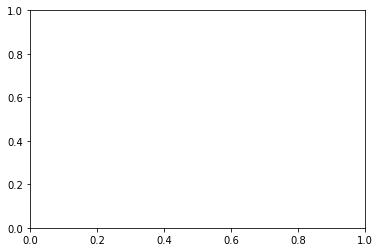

In [11]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

for name in ["training_keys", "validation_keys"]:
    d = result[name]
    x = d["FP"]/(d["FP"]+d["TN"])
    y = d["TP"]/(d["TP"]+d["FN"])
    index = 10
    ax.plot(x,y, linestyle="-", linewidth=1, markersize=5, marker=".", label=name)
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.text(x[index]+0.05, y[index]-0.05, "threshold={}".format(np.linspace(0,1,n_points)[index]), color="green")
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"ROC ball detection from PIFPAF")
    ax.legend()
plt.show()

True